### Big Data Computing - Assignment 4 - Tataru Ion 

# Finding the number of triangles in a social graph with Spark
In this application, we are given a file, representing a sample of a the [LiveJournal](https://www.livejournal.com/) social network that you find at https://snap.stanford.edu/data/soc-LiveJournal1.html. The network is undirected and is described by a ```tab```-separated text file with the following format:

```7	0,31993,40218,40433,1357,21843```

The first number is the id of a node of the network. It is follow by a comma-separated list of its neighbours. The original dataset was used and is described in the following papers:

- L. Backstrom, D. Huttenlocher, J. Kleinberg, X. Lan. Group Formation in Large Social Networks: Membership, Growth, and Evolution. KDD, 2006.
- J. Leskovec, K. Lang, A. Dasgupta, M. Mahoney. Community Structure in Large Networks: Natural Cluster Sizes and the Absence of Large Well-Defined Clusters. Internet Mathematics 6(1) 29--123, 2009.


## Your assignment
Your are asked to compute the number of triangles in the graph, i.e., the total number of *unordered* triples
$\:(a,b,c)\:$  of vertices that form **3-cliques**. In general, solving the problem can be computationally expensive, in
the order of $\: \Theta(n^3) \:$ , with  $n$  the number of vertices in the graph. On the other hand, the number of triangles
in a (undirected) network is a key indicator of the degree of cohesiveness and social structure. In particular,
the number of triangles is necessary to compute the *global clustering coefficient*. In particular, the global
clustering coefficient of a network is defined as:

$$
C = \dfrac{<\:Number \: of \: triangles \: in \: G \:>}{\binom{n}{3}}
$$

## Solving using Spark
As usual, you find a solution that is not optimized. Still, the solution you find here essentially follows the
basic MapReduce implementation of the NodeIterator algorithm presented in

Suri, Siddharth, and Sergei Vassilvitskii. "[Counting triangles and the curse of the last reducer.](https://theory.stanford.edu/~sergei/papers/www11-triangles.pdf)" In Proceedings of
the 20th international conference on World wide web, pp. 607-614. ACM, 2011.

Resource 2: Meysam Taassori  ["L16: Counting Triangles in MapReduce"](https://www.cs.utah.edu/~jeffp/teaching/MCMD/S16-MR-triangles.pdf)

| 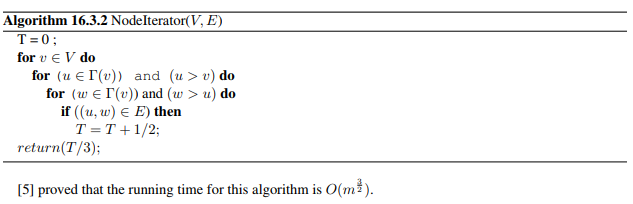 |
|:--:|
| <center><i><b>NodeIterator++ Algorithm<b><i><center> |

| 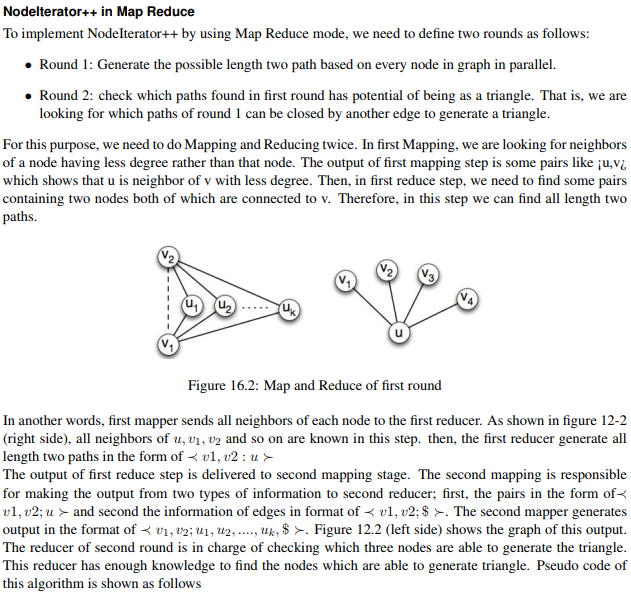 |
|:--:|

| 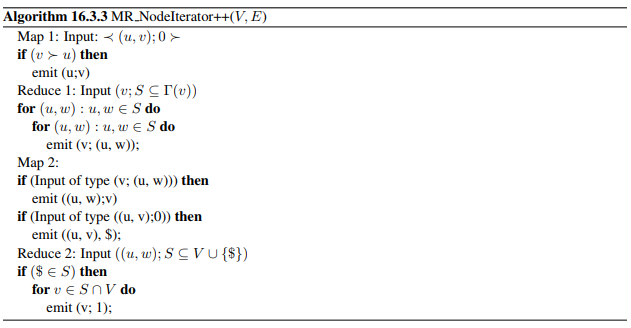 |
|:--:|
| <center><i><b>NodeIterator++ in MapReduce<b><i><center> |

We next initialize our application using ```SparkConf``` and then creating a ```SparkContext``` object. Note that we are now working in local mode. We also assign enough memory to the driver program. Otherwise, using default values with this dataset we would experience a memory error when collecting results.

In [1]:
from pyspark import SparkContext, SparkConf

In [2]:
sc = SparkContext.getOrCreate()
sc.stop()

my_config = ( SparkConf()
              .setMaster("local")
              .setAppName("Triangles_Count")
              .set("spark.executor.memory", "4g") )

sc = SparkContext(conf=my_config)

In [3]:
base_path   = "C:/Users/tatar/Spark/"
file_sample = base_path + "SparkProjects/BD_A4/data/check_sample.txt"
file_full   = base_path + "SparkProjects/BD_A4/data/soc-LiveJournal1Adj.txt"
out_file    = base_path + "SparkProjects/BD_A4/data/count_triangles_out.txt"

We load data, creating an RDD corresponding to our input file:

In [4]:
f = sc.textFile(file_full)

In [5]:
f.take(10)

['0\t1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94',
 '1\t0,5,20,135,2409,8715,8932,10623,12347,12846,13840,13845,14005,20075,21556,22939,23520,28193,29724,29791,29826,30691,31232,31435,32317,32489,34394,35589,35605,35606,35613,35633,35648,35678,38737,43447,44846,44887,49226,49985,623,629,4999,6156,13912,14248,15190,17636,19217,20074,27536,29481,29726,29767,30257,33060,34250,34280,34392,34406,34418,34420,34439,34450,34651,45054,49592',
 '2\t0,117,135,1220,2755,12453,24539,24714,41456,45046,49927,6893,13795,16659,32828,41878',
 '3\t0,12,41,55,1532,12636,13185,27552,38737',
 '4\t0,8,14,15,18,27,72,80,15326,19068,19079,24596,42697,46126,74,77,33269,38792,38822',
 '5\t0,1,20,2022,22939,23527,30257,32503,35633,41457,43262,44846,49574,31140,32828',
 '6\t0,21,98,2203,32

We next extract the adjacency list of every node. For example, for the following line of the input file:

```7	0,31993,40218,40433,1357,21843```

We have the following tuple:

```(7, [0,31993,40218,40433,1357,21843])```

#### Filtering
We need to consider that some nodes may have 0 or 1 neghbours (we need at least two neghbors to form a triangle). These nodes should be filtered out. To this purpose, we define the following function: 

In [6]:
def check(line):
    if len(line.split()) > 1:
           return len((line.split())[1].split(',')) > 1
    return False

At this point we can compute the aforementioned adjacency lists:

In [7]:
adlists = f.filter(check).map(lambda line: line.split())
adlists = adlists.map(lambda l: (l[0], l[1].split(',')))

Now we have the following adjacency list:

```(7, [0,31993,40218,40433,1357,21843])```

Al pairs of nodes appearing in the list have node  $\: 7 \:$  as their common neighbour.

<img src="MapReduceTriangles.jpg" alt="drawing" width="50%"/>

In [8]:
""" Original INPUT
    [('1', ['2', '3', '4']),
     ('2', ['1', '3']),
     ('3', ['1', '2', '4']),
     ('4', ['1', '3'])]
"""
def map_1( v_neighbors  ):
    """To avoid double triangle counting, we consider just the neighbors with number greater then the considered vertex."""
    l = []
    for neighbor in v_neighbors[1]:
        if int(v_neighbors[0]) < int(neighbor) :
            l.append( neighbor )
    return (v_neighbors[0], l)
    
    
""" Next INPUT
    [('1', ['2', '3', '4']), 
     ('2', ['3']), 
     ('3', ['4']), 
     ('4', [])]
"""
def map_2( tup ):
    """Emmits just the potential triangles and mark the edges of the considered node"""
    l = []
    for e1 in tup[1]:
        l.append( ((tup[0], e1) , "$") )   # mark the <e1> edges with '$' 
        for e2 in tup[1]:
            if (int(e1) < int(e2)):
                l.append( ((e1, e2) , tup[0]) )
    return l


""" Next INPUT (after  .groupByKey().mapValues(list)  )
    [(('1', '2'), ['$']),
     (('2', '3'), ['1', '$']),
     (('2', '4'), ['1']),
     (('1', '3'), ['$']),
     (('3', '4'), ['1', '$']),
     (('1', '4'), ['$'])]
"""
def map_3( tup ):
    """Emmits the real triangles, ordering the vertexes number to avoid multi-counting of the same triangles further."""
    if ('$' not in tup[1]):
        return []    # no triangles to return
    
    l  = []
    for v in tup[1]:
        if (v is not '$'):
            triangle = list(tup[0])
            triangle.append(v)
            triangle.sort(key=int)
            l.append( (tuple(triangle) , 1) )
    return l

In [9]:
from time import time

In [10]:
count_init    = time()

triangles     = adlists.map( map_1 ).flatMap( map_2 ).groupByKey().mapValues(list).flatMap( map_3 ).reduceByKey(lambda a, b: a+b).persist()
                # After doing   .groupByKey().mapValues(list)   we have the result of (ReduceByKey)
                #   .mapValues(list) serve to convert the PySpark iterable objects into lists;
        
num_triangles = triangles.count()

print("\nnum_triangles = < {:,} > ".format(num_triangles))

print("\nTime passed to count the triangles: < {} > sec. \n".format(round(time() - count_init, 2)))


num_triangles = < 757,243 > 

Time passed to count the triangles: < 166.2 > sec. 



In [11]:
triangles.take(1000)

[(('8859', '13829', '23573'), 1),
 (('9281', '13829', '23573'), 1),
 (('8671', '22940', '40455'), 1),
 (('3999', '22940', '40455'), 1),
 (('6019', '22940', '40455'), 1),
 (('638', '22940', '40455'), 1),
 (('4364', '22940', '40455'), 1),
 (('8399', '22940', '40455'), 1),
 (('36727', '37150', '44099'), 1),
 (('37018', '37150', '44099'), 1),
 (('36933', '37150', '44099'), 1),
 (('36874', '37150', '44099'), 1),
 (('36862', '37188', '38573'), 1),
 (('36862', '38574', '41367'), 1),
 (('38474', '38574', '41367'), 1),
 (('37537', '38574', '41367'), 1),
 (('161', '16680', '23623'), 1),
 (('6117', '16680', '23623'), 1),
 (('6109', '16680', '23623'), 1),
 (('184', '29783', '43202'), 1),
 (('15146', '29783', '43202'), 1),
 (('29753', '29783', '43202'), 1),
 (('3333', '3344', '3353'), 1),
 (('3304', '3344', '3353'), 1),
 (('3333', '3365', '3374'), 1),
 (('3304', '3365', '3374'), 1),
 (('3347', '3365', '3374'), 1),
 (('3362', '3365', '3374'), 1),
 (('6612', '7047', '38206'), 1),
 (('7041', '7047', '

I tested the code on a small sample with 2 triangles like the one in the photo above. Change `f = sc.textFile(file_full)` into `f = sc.textFile(file_sample)` to test it. Also you'll need to change the base path where the project folder is stored in the FS.

In [12]:
with open(out_file, 'w', encoding="utf8") as fd_out:
    fd_out.write("num_triangles: " + str(num_triangles) + "\n")

In [13]:
sc.stop()